In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cupy as cp
from torchvision.transforms import ToTensor, Grayscale, Compose, ToPILImage, Resize
import torchvision.transforms.functional as TF
from scipy import stats
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from functools import partial
import numpy as np
import ctypes as ct

from icecream import ic
from contexttimer import Timer
from einops.layers.torch import Rearrange, Reduce

In [ ]:
def show_array(x):
    if type(x) == torch.Tensor:
        if x.device.type == 'cuda':
            x = x.clone().cpu()
            
    x = x.squeeze()
    plt.imshow(x)
    plt.axis('off')
    plt.show()

In [ ]:
# Using nn.Module as I am thinking of extending sep filter with CNN
# and perhaps GPUs later

class SeparabilityFilter(nn.Module):
    def __init__(self):
        super().__init__()
        pass
    
    def forward(self, x):
        return x+2

In [ ]:
sep_filter = SeparabilityFilter()
x = 2
sep_filter(x)

4

# CPU vs GPU Speed Comparison

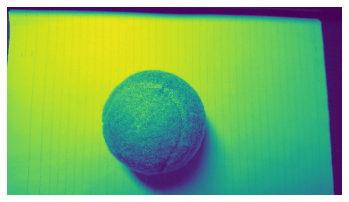

In [ ]:
img = Image.open('testimages/DSC_3136.JPG')
h,w = img.size
transform = Compose([
    ToTensor(),
    Grayscale(),
    Resize((w//10, h//10)),
])
x = transform(img)
show_array(x)

## Integral Image 

In [ ]:
# numpy input
x_cpu = np.asarray(x).squeeze()
print(x_cpu.shape, type(x_cpu))

# tensor (on gpu) input
device = torch.device("cuda:0" )  
x_gpu = x.to(device=device)
print(x_gpu.shape, type(x_gpu), x_gpu.device)

(309, 550) <class 'numpy.ndarray'>
torch.Size([1, 309, 550]) <class 'torch.Tensor'> cuda:0


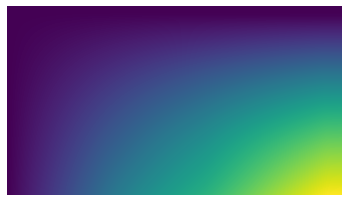

cpu: 0.001


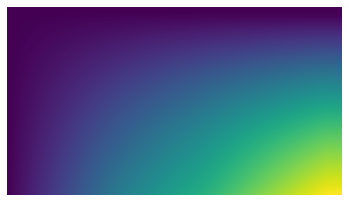

gpu: 0.000


In [ ]:
# Integral Image
# https://en.wikipedia.org/wiki/Summed-area_table

def cvtIntegralImage(X):
    X = X.squeeze()
    H, W = X.shape
    Z = np.zeros((H+1, W+1), np.float64)
    Z[1:,1:] = np.cumsum(np.cumsum(X,0),1)
    return Z

def integral_image(X):
    for i in range(X.ndim):
        X = X.cumsum(i)
    return X

with Timer() as t:
    y = cvtIntegralImage(x_cpu)
show_array(y)
print("cpu:", t)

with Timer() as t:
    y = integral_image(x_gpu)
show_array(y)
print("gpu:", t)

## Pointwise Square

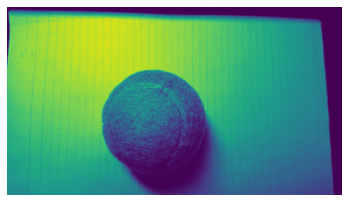

cpu: 0.002


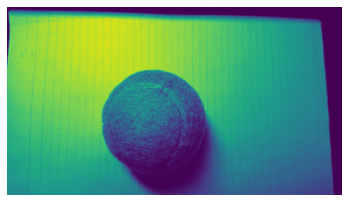

gpu: 0.001


In [ ]:
with Timer() as t:
    y = np.power(x_cpu, 2)
show_array(y)
print("cpu:", t)

with Timer() as t:
    y = torch.pow(x_gpu, 2)
show_array(y)
print("gpu:", t)

## 45 Integral Image 

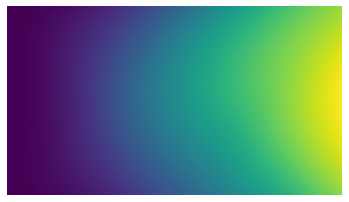

cpu: 0.002


In [ ]:
# 45 Integral Image
# https://en.wikipedia.org/wiki/Summed-area_table

lib_cvtII45 = np.ctypeslib.load_library("lib_cvtIntegralImage45.so","utils")
_FLOAT64_PP = np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
#SetCHLAC()関数の引数の型を指定(ctypes)　
lib_cvtII45.cvtIntegralImage45.argtypes = [_FLOAT64_PP, ct.c_int, ct.c_int, _FLOAT64_PP]
#SetCHLAC()関数が返す値の型を指定(今回は返り値なし)
lib_cvtII45.cvtIntegralImage45.restype = None

def cvtIntegralImage45(X):
    X = X.squeeze()
    H, W = X.shape
    Z = np.zeros((H+2, W+1), np.float64)
    Z[1:-1, 1:] = X
    tmpX = Z.copy()
    Z = Z.flatten()
    lib_cvtII45.cvtIntegralImage45(Z, int(H+2), int(W+1), tmpX.flatten())
    Z = Z.reshape(H+2, W+1)
    Z=Z[1:,:]
    return Z

with Timer() as t:
    y = cvtIntegralImage45(x_cpu)
show_array(y)
print("cpu:", t)

I think we can rotate the image first, and then compute

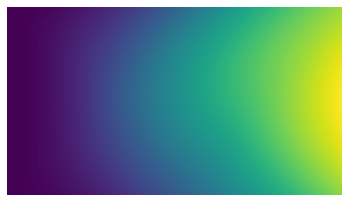

gpu: 0.004


In [ ]:
def integral_image_45(X):
    X_45 = TF.rotate(X, angle=-45, expand=True)
    for i in range(X_45.ndim):
        X_45 = X_45.cumsum(i)
    X = TF.center_crop(TF.rotate(X_45, angle=45, expand=True), X.shape[1:])
    return X

with Timer() as t:    
    y = integral_image_45(x_gpu)
    
show_array(y)
print("gpu:", t)

## Combined Simple Rectangular Filter

ic| r: 200, bh: 200, H: 939, bw: 34, W: 1180
<ipython-input-20-e235a588ccee>:64: RuntimeWarning: divide by zero encountered in true_divide
  MAP[r:H-r,r:W-r] = (Sb/St)*np.sign(M2-M1)
<ipython-input-20-e235a588ccee>:64: RuntimeWarning: invalid value encountered in true_divide
  MAP[r:H-r,r:W-r] = (Sb/St)*np.sign(M2-M1)
ic| r: 200, bh: 34, H: 939, bw: 200, W: 1180


0.069


<ipython-input-20-e235a588ccee>:117: RuntimeWarning: invalid value encountered in true_divide
  MAP[h-1:-h,h-1:-h]=(Sb/St)*np.sign(M2-M1)


0.562


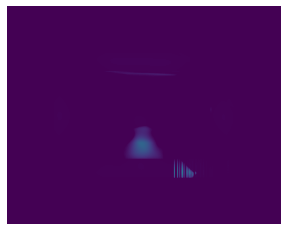

In [ ]:
def cvtCombSimpRectFilter(I,P,sh):
    bh = sh*2
    bw = np.ceil(sh/3).astype(np.int64)
    sw = np.ceil(sh/3).astype(np.int64)
    dh = 0
    dw = 0
    
    MAP   = np.zeros((I.shape[0]-1, I.shape[1]-1, 2), np.float64)
    
    MAP[:,:,0] = tmpFnc(I,P,bh,bw,sh,sw,dh,dw)
    MAP[:,:,1] = tmpFnc(I,P,bw,bh,sw,sh,dh,dw)
    
    return MAP

def cvtCombSimpRectFilter45(I,P,sh):
    
    r = np.round(sh/np.sqrt(2)).astype(np.int64)
    w = np.ceil(sh/3/np.sqrt(2)).astype(np.int64)
    br = 2*r
    
    MAP   = np.zeros((I.shape[0]-1, I.shape[1]-1, 2), np.float64)

    MAP[:,:,0] = tmpFnc45(I,P,r,br,w,w)
    MAP[:,:,1] = tmpFnc45(I,P,w,w,r,br)
    
    
    return MAP#

def tmpFnc(I,P,bh,bw,sh,sw,dh,dw):
    MAP   = np.zeros((I.shape[0]-1, I.shape[1]-1), np.float64)
    H,W = MAP.shape
    r = np.max([bh,bw])
    N  = (2*bh+1)*(2*bw+1)
    N1 = (2*sh+1)*(2*sw+1)
    N2 = N-N1
    ic(r, bh, H, bw, W)

    S = (
        I[r -bh  :H-r -bh   ,r -bw  :W-r -bw  ]
      + I[r +bh+1:H-r +bh+1 ,r +bw+1:W-r +bw+1]
      - I[r -bh  :H-r -bh   ,r +bw+1:W-r +bw+1]
      - I[r +bh+1:H-r +bh+1 ,r -bw  :W-r -bw  ]
    )
    T = (
        P[r -bh  :H-r -bh   ,r -bw  :W-r -bw  ]
      + P[r +bh+1:H-r +bh+1 ,r +bw+1:W-r +bw+1]
      - P[r -bh  :H-r -bh   ,r +bw+1:W-r +bw+1]
      - P[r +bh+1:H-r +bh+1 ,r -bw  :W-r -bw  ]
    )
    M = S/N
    Y = T/N
    St = Y - np.power(M, 2)
    S1 = (
         I[r -sh+dh  :H-r -sh+dh   ,r -sw+dw  :W-r -sw+dw]
       + I[r +sh+dh+1:H-r +sh+dh+1,r +sw+dw+1:W-r +sw+dw+1]
       - I[r -sh+dh  :H-r -sh+dh  ,r +sw+dw+1:W-r +sw+dw+1]
       - I[r +sh+dh+1:H-r +sh+dh+1,r -sw+dw  :W-r -sw+dw]
    )
    S2=S-S1
    M1=S1/N1
    M2=S2/N2

    Sb = ((N1*(np.power(M1-M, 2))) + (N2*(np.power(M2-M, 2))))/N
    MAP[r:H-r,r:W-r] = (Sb/St)*np.sign(M2-M1)
    MAP[np.isnan(MAP)]=0
    MAP[np.isinf(MAP)]=0

    return MAP

def tmpFnc45(I,P,r,br,w,bw):
    MAP   = np.zeros((I.shape[0]-1, I.shape[1]-1), np.float64)
    H,W = MAP.shape
    
    h = bw+br+2
    N =(2*bw+1)*(2*(1+2*br))
    N1=(2*w+1)*(2*(1+2*r))
    N2=N-N1
    
    
    HH1 = bw + br +1+1 -1
    HH2 = H-(bw + br +2)
    WW1 = bw + br +3    -1     
    WW2 = W-(bw + br+1)
    
    P1 = I[HH1 - bw - br -1  :HH2 - bw - br -1  ,WW1 + bw - br - 1   :WW2 + bw - br - 1  ]
    P2 = I[HH1 + bw - br -1+1:HH2 + bw - br -1+1,WW1 - bw - br - 1-1:WW2 - bw - br - 1-1 ]
    P3 = I[HH1 + bw + br +1  :HH2 + bw + br +1  ,WW1 - bw + br - 1  :WW2 - bw + br - 1   ]
    P4 = I[HH1 - bw + br     :HH2 - bw + br      ,WW1 + bw + br      :WW2 + bw + br      ]

    S = (P4+P2-P3-P1)
    

    P1 = P[HH1 - bw - br -1  :HH2 - bw - br -1  ,WW1 + bw - br - 1   :WW2 + bw - br - 1  ]
    P2 = P[HH1 + bw - br -1+1:HH2 + bw - br -1+1,WW1 - bw - br - 1-1:WW2 - bw - br - 1-1 ]
    P3 = P[HH1 + bw + br +1  :HH2 + bw + br +1  ,WW1 - bw + br - 1  :WW2 - bw + br - 1   ]
    P4 = P[HH1 - bw + br     :HH2 - bw + br      ,WW1 + bw + br      :WW2 + bw + br      ]
    T= (P4+P2-P3-P1)
    
    

    M = S/N
    Y = T/N
    St = Y - np.power(M, 2)

    P1 = I[HH1 - w - r -1  :HH2 - w - r -1  ,WW1 + w - r - 1    :WW2 + w - r - 1]
    P2 = I[HH1 + w - r -1+1:HH2 + w - r -1+1,WW1 - w - r - 1-1  :WW2 - w - r - 1-1  ]
    P3 = I[HH1 + w + r +1  :HH2 + w + r +1  ,WW1 - w + r - 1    :WW2 - w + r - 1]
    P4 = I[HH1 - w + r     :HH2 - w + r     ,WW1 + w + r         :WW2 + w + r    ]
    S1= (P4+P2-P3-P1);

    S2=S-S1
    M1=S1/N1
    M2=S2/N2

    Sb = ((N1*(np.power(M1-M, 2))) + (N2*(np.power(M2-M, 2))))/N;

    MAP[h-1:-h,h-1:-h]=(Sb/St)*np.sign(M2-M1)
    MAP[np.isnan(MAP)]=0
    MAP[np.isinf(MAP)]=0
    
    return MAP


def add_margin(cv_gray_img, top, right, bottom, left):
    height, width = cv_gray_img.shape
    new_width = width + right + left
    new_height = height + top + bottom
    result = np.zeros((new_height, new_width))
    result[top:-bottom, left:-right] = cv_gray_img
    return result

with Timer() as t:
    nR = 100
    x_cpu = add_margin(x_cpu, nR, nR, nR, nR)
    x_cpu = x_cpu.astype(np.float64)
    H, W = x_cpu.shape
    
    I1 = cvtIntegralImage(x_cpu)
    P1 = cvtIntegralImage(x_cpu**2)   
    I2 = cvtIntegralImage45(x_cpu)        
    P2 = cvtIntegralImage45(x_cpu**2)
    print(t)
        
    P = np.zeros((H,W,4), np.float64)
    P[:,:,0:2] =  cvtCombSimpRectFilter(I1,P1,nR)  # apply vertical and horizontal rectangular filters
    P[:,:,2:4] = cvtCombSimpRectFilter45(I2,P2,nR)  # apply vertical and horizontal rectangular filters
    P[P<=0]=0
    finalMap1 = stats.gmean(P[:,:,0:4]+1e-8, 2)
    
print(t)
show_array(finalMap1)

In [ ]:
def cvtCombSimpRectFilter(I,P,sh):
    bh = ic(sh.type(torch.LongTensor)*2).to(device)
    bw = torch.ceil(sh/3).type(torch.LongTensor).to(device)
    sw = torch.ceil(sh/3).type(torch.LongTensor).to(device).to(device)
    dh = torch.LongTensor([0]).to(device)
    dw = torch.LongTensor([0]).to(device)

    MAP   = torch.zeros((I.shape[0]-1, I.shape[1]-1, 2), dtype=torch.float64)
    
    MAP[:,:,0] = tmpFnc(I,P,bh,bw,sh,sw,dh,dw)
    MAP[:,:,1] = tmpFnc(I,P,bw,bh,sw,sh,dh,dw)
    
    return MAP

def cvtCombSimpRectFilter45(I,P,sh):
    
    r = torch.round(sh/np.sqrt(2)).type(torch.LongTensor)
    w = torch.ceil(sh/3/np.sqrt(2)).type(torch.LongTensor)
    br = 2*r
    
    MAP   = torch.zeros((I.shape[0]-1, I.shape[1]-1, 2), dtype=torch.float64)

    MAP[:,:,0] = tmpFnc45(I,P,r,br,w,w)
    MAP[:,:,1] = tmpFnc45(I,P,w,w,r,br)
    
    
    return MAP#

def tmpFnc(I,P,bh,bw,sh,sw,dh,dw):
    MAP   = torch.zeros((I.shape[0]-1, I.shape[1]-1), dtype=torch.float64)
    H,W = MAP.shape
    
    r = torch.cat((bw, bw)).max().type(torch.LongTensor)
    N  = (2*bh+1)*(2*bw+1)
    N1 = (2*sh+1)*(2*sw+1)
    N2 = N-N1
    
    ic(r, bh, H, bw, W, dh)
    S = (
        I[r -bh  :H-r -bh   ,r -bw  :W-r -bw  ]
      + I[r +bh+1:H-r +bh+1 ,r +bw+1:W-r +bw+1]
      - I[r -bh  :H-r -bh   ,r +bw+1:W-r +bw+1]
      - I[r +bh+1:H-r +bh+1 ,r -bw  :W-r -bw  ]
    )
    T = (
        P[r -bh  :H-r -bh   ,r -bw  :W-r -bw  ]
      + P[r +bh+1:H-r +bh+1 ,r +bw+1:W-r +bw+1]
      - P[r -bh  :H-r -bh   ,r +bw+1:W-r +bw+1]
      - P[r +bh+1:H-r +bh+1 ,r -bw  :W-r -bw  ]
    )
    M = S/N
    Y = T/N
    St = Y - torch.pow(M, 2)
    S1 = (
         I[r -sh+dh  :H-r -sh+dh   ,r -sw+dw  :W-r -sw+dw]
       + I[r +sh+dh+1:H-r +sh+dh+1,r +sw+dw+1:W-r +sw+dw+1]
       - I[r -sh+dh  :H-r -sh+dh  ,r +sw+dw+1:W-r +sw+dw+1]
       - I[r +sh+dh+1:H-r +sh+dh+1,r -sw+dw  :W-r -sw+dw]
    )
    S2=S-S1
    M1=S1/N1
    M2=S2/N2

    Sb = ((N1*(torch.pow(M1-M, 2))) + (N2*(torch.pow(M2-M, 2))))/N
    MAP[r:H-r,r:W-r] = (Sb/St)*torch.sign(M2-M1)
    MAP[torch.isnan(MAP)]=0
    MAP[torch.isinf(MAP)]=0

    return MAP

def tmpFnc45(I,P,r,br,w,bw):
    MAP   = torch.zeros((I.shape[0]-1, I.shape[1]-1), dtype=torch.float64)
    H,W = MAP.shape
    
    h = bw+br+2
    N =(2*bw+1)*(2*(1+2*br))
    N1=(2*w+1)*(2*(1+2*r))
    N2=N-N1
    
    
    HH1 = bw + br +1+1 -1
    HH2 = H-(bw + br +2)
    WW1 = bw + br +3    -1     
    WW2 = W-(bw + br+1)
    
    P1 = I[HH1 - bw - br -1  :HH2 - bw - br -1  ,WW1 + bw - br - 1   :WW2 + bw - br - 1  ]
    P2 = I[HH1 + bw - br -1+1:HH2 + bw - br -1+1,WW1 - bw - br - 1-1:WW2 - bw - br - 1-1 ]
    P3 = I[HH1 + bw + br +1  :HH2 + bw + br +1  ,WW1 - bw + br - 1  :WW2 - bw + br - 1   ]
    P4 = I[HH1 - bw + br     :HH2 - bw + br      ,WW1 + bw + br      :WW2 + bw + br      ]

    S = (P4+P2-P3-P1)
    

    P1 = P[HH1 - bw - br -1  :HH2 - bw - br -1  ,WW1 + bw - br - 1   :WW2 + bw - br - 1  ]
    P2 = P[HH1 + bw - br -1+1:HH2 + bw - br -1+1,WW1 - bw - br - 1-1:WW2 - bw - br - 1-1 ]
    P3 = P[HH1 + bw + br +1  :HH2 + bw + br +1  ,WW1 - bw + br - 1  :WW2 - bw + br - 1   ]
    P4 = P[HH1 - bw + br     :HH2 - bw + br      ,WW1 + bw + br      :WW2 + bw + br      ]
    T= (P4+P2-P3-P1)
    
    

    M = S/N
    Y = T/N
    St = Y - np.power(M, 2)

    P1 = I[HH1 - w - r -1  :HH2 - w - r -1  ,WW1 + w - r - 1    :WW2 + w - r - 1]
    P2 = I[HH1 + w - r -1+1:HH2 + w - r -1+1,WW1 - w - r - 1-1  :WW2 - w - r - 1-1  ]
    P3 = I[HH1 + w + r +1  :HH2 + w + r +1  ,WW1 - w + r - 1    :WW2 - w + r - 1]
    P4 = I[HH1 - w + r     :HH2 - w + r     ,WW1 + w + r         :WW2 + w + r    ]
    S1= (P4+P2-P3-P1);

    S2=S-S1
    M1=S1/N1
    M2=S2/N2

    Sb = ((N1*(np.power(M1-M, 2))) + (N2*(np.power(M2-M, 2))))/N;

    MAP[h-1:-h,h-1:-h]=(Sb/St)*np.sign(M2-M1)
    MAP[np.isnan(MAP)]=0
    MAP[np.isinf(MAP)]=0
    
    return MAP


def add_margin(cv_gray_img, top, right, bottom, left):
    height, width = cv_gray_img.shape
    new_width = width + right + left
    new_height = height + top + bottom
    result = np.zeros((new_height, new_width))
    result[top:-bottom, left:-right] = cv_gray_img
    return result

with Timer() as t:
    nR = 85
#     x_cpu+ = add_margin(x_gpu, nR, nR, nR, nR)
#     x_cpu = x_cpu.astype(np.float64)
    H, W = x_gpu.shape[1:]
    
    I1 = integral_image(x_gpu)
    P1 = integral_image(torch.pow(x_gpu, 2))   
#     I2 = integral_image_45(x_gpu)        
#     P2 = integral_image_45(torch.pow(x_gpu, 2))
        
#     P = np.zeros((H,W,4), np.float64)
#     P[:,:,0:2] =  cvtCombSimpRectFilter(I1,P1,nR)  # apply vertical and horizontal rectangular filters
#     P[:,:,2:4] = cvtCombSimpRectFilter45(I2,P2,nR)  # apply vertical and horizontal rectangular filters
#     P[P<=0]=0
#     finalMap1 = stats.gmean(P[:,:,0:4]+1e-8, 2)
    
#     show_array(finalMap1)
    
print(t)

0.008


In [ ]:
nR = ic(torch.LongTensor([85])).to(device)
P = torch.zeros((H,W,4)).to(device)
P[:,:,0:2] =  cvtCombSimpRectFilter(I1.squeeze(),P1.squeeze(),nR)  # apply vertical and horizontal rectangular filters
P[:,:,2:4] = cvtCombSimpRectFilter45(I2,P2,nR)  # apply vertical and horizontal rectangular filters
P[P<=0]=0
finalMap1 = stats.gmean(P[:,:,0:4]+1e-8, 2)

show_array(finalMap1)

ic| torch.LongTensor([85]): tensor([85])
ic| sh.type(torch.LongTensor)*2: tensor([170])
ic| r: tensor(29)
    bh: tensor([170], device='cuda:0')
    H: 308
    bw: tensor([29], device='cuda:0')
    W: 549
    dh: tensor([0], device='cuda:0')


RuntimeError: The size of tensor a (0) must match the size of tensor b (109) at non-singleton dimension 0

In [ ]:
sh = torch.Tensor(85)
bh = sh*2
bw = torch.ceil(sh/3)
sw = torch.ceil(sh/3)
torch.max((bw.numpy(), sw.numpy()))

In [ ]:
%timeit torch.stack((bw, sw)).max()

In [ ]:
%timeit torch.cat((bw, sw)).max()

In [ ]:
def cvtCombSimpRectFilter(I,P,sh):
    bh = ic(sh.type(torch.LongTensor)*2).to(device)
    bw = torch.ceil(sh/3).type(torch.LongTensor).to(device)
    sw = torch.ceil(sh/3).type(torch.LongTensor).to(device).to(device)
    dh = torch.LongTensor([0]).to(device)
    dw = torch.LongTensor([0]).to(device)

    MAP   = torch.zeros((I.shape[0]-1, I.shape[1]-1, 2), dtype=torch.float64)
    
    MAP[:,:,0] = tmpFnc(I,P,bh,bw,sh,sw,dh,dw)
    MAP[:,:,1] = tmpFnc(I,P,bw,bh,sw,sh,dh,dw)
    
    return MAP

def tmpFnc(I,P,bh,bw,sh,sw,dh,dw):
    MAP   = torch.zeros((I.shape[0]-1, I.shape[1]-1), dtype=torch.float64)
    H,W = MAP.shape
    
    r = torch.cat((bw, bw)).max().type(torch.LongTensor)
    N  = (2*bh+1)*(2*bw+1)
    N1 = (2*sh+1)*(2*sw+1)
    N2 = N-N1
    
    ic(r, bh, H, bw, W, dh)
    S = (
        I[r -bh  :H-r -bh   ,r -bw  :W-r -bw  ]
      + I[r +bh+1:H-r +bh+1 ,r +bw+1:W-r +bw+1]
      - I[r -bh  :H-r -bh   ,r +bw+1:W-r +bw+1]
      - I[r +bh+1:H-r +bh+1 ,r -bw  :W-r -bw  ]
    )
    T = (
        P[r -bh  :H-r -bh   ,r -bw  :W-r -bw  ]
      + P[r +bh+1:H-r +bh+1 ,r +bw+1:W-r +bw+1]
      - P[r -bh  :H-r -bh   ,r +bw+1:W-r +bw+1]
      - P[r +bh+1:H-r +bh+1 ,r -bw  :W-r -bw  ]
    )
    M = S/N
    Y = T/N
    St = Y - torch.pow(M, 2)
    S1 = (
         I[r -sh+dh  :H-r -sh+dh   ,r -sw+dw  :W-r -sw+dw]
       + I[r +sh+dh+1:H-r +sh+dh+1,r +sw+dw+1:W-r +sw+dw+1]
       - I[r -sh+dh  :H-r -sh+dh  ,r +sw+dw+1:W-r +sw+dw+1]
       - I[r +sh+dh+1:H-r +sh+dh+1,r -sw+dw  :W-r -sw+dw]
    )
    S2=S-S1
    M1=S1/N1
    M2=S2/N2

    Sb = ((N1*(torch.pow(M1-M, 2))) + (N2*(torch.pow(M2-M, 2))))/N
    MAP[r:H-r,r:W-r] = (Sb/St)*torch.sign(M2-M1)
    MAP[torch.isnan(MAP)]=0
    MAP[torch.isinf(MAP)]=0

    return MAP


def add_margin(cv_gray_img, top, right, bottom, left):
    height, width = cv_gray_img.shape
    new_width = width + right + left
    new_height = height + top + bottom
    result = np.zeros((new_height, new_width))
    result[top:-bottom, left:-right] = cv_gray_img
    return result

with Timer() as t:
    nR = 85
#     x_cpu+ = add_margin(x_gpu, nR, nR, nR, nR)
#     x_cpu = x_cpu.astype(np.float64)
    H, W = x_gpu.shape[1:]
    
    I1 = integral_image(x_gpu)
    P1 = integral_image(torch.pow(x_gpu, 2))   
#     I2 = integral_image_45(x_gpu)        
#     P2 = integral_image_45(torch.pow(x_gpu, 2))
        
#     P = np.zeros((H,W,4), np.float64)
#     P[:,:,0:2] =  cvtCombSimpRectFilter(I1,P1,nR)  # apply vertical and horizontal rectangular filters
#     P[:,:,2:4] = cvtCombSimpRectFilter45(I2,P2,nR)  # apply vertical and horizontal rectangular filters
#     P[P<=0]=0
#     finalMap1 = stats.gmean(P[:,:,0:4]+1e-8, 2)
    
#     show_array(finalMap1)
    
print(t)

0.004
